In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

import os
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import data_extraction as da
import modelling as md
import plotting
import utils

# TODO: consider clustering ordinal results to show patterns (types of films)
# TODO: comment on franchises
# TODO: add confirmed genres to ratings table, primary/secondary, studio?

# Prediction on unseen films (Annie Hall, Chariots of Fire, The Silence of the Lambs, The Departed)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eye4got/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
films_list_df = da.get_or_create_subtitles_data(os.path.join(da.sub_dir, 'movie_index.parquet'), da.sub_dir)

full_subs_df_list = []
movie_names = set()

for movie_cat in ('Blockbusters', 'Oscar'):
    for year in films_list_df.year.unique():
        year_dir = os.path.join(da.sub_by_year_dir, movie_cat, str(year))
        for movie_fp in os.listdir(year_dir):
            curr_df = da.extract_single_subs_file(os.path.join(year_dir, movie_fp))
            curr_movie = utils.remove_ext(movie_fp)
            
            # Handle repeat titles like The Little Mermaid by adding the year to subsequent productions
            if curr_movie in movie_names:
                curr_df['movie'] = curr_movie + f' ({str(year)})'
                films_list_df.loc[films_list_df.movie.eq(curr_movie) & films_list_df.year.eq(year), 'movie'] = curr_movie + f' ({str(year)})'
            else:
                movie_names.add(curr_movie)
            
            full_subs_df_list.append(curr_df)
          
for movie in os.listdir(da.add_sub_dir):
    if movie.endswith('.srt'):
        curr_df = da.extract_single_subs_file(os.path.join(da.add_sub_dir, movie))
        full_subs_df_list.append(curr_df)
    
full_subs_df = pd.concat(full_subs_df_list)

full_subs_df['movie'] = full_subs_df['movie'].str.strip().str.replace('-', ' ').str.replace('.', '').str.title()
films_list_df['movie'] = films_list_df['movie'].str.strip().str.replace('-', ' ').str.replace('.', '').str.replace("'", ' ').str.replace('&', 'and').str.title()

films_list_df.loc[films_list_df.movie.eq('Don T Look Up'), 'movie'] = 'Dont Look Up'
films_list_df.loc[films_list_df.movie.eq('Goodbye,Columbus'), 'movie'] = 'Goodbye Columbus'
films_list_df.loc[films_list_df.movie.eq('Summer of  42'), 'movie'] = 'Summer of 42'
films_list_df.loc[films_list_df.movie.eq('What s Up, Doc_'), 'movie'] = 'What s Up, Doc'
films_list_df.loc[films_list_df.movie.eq('Monsters, Inc.'), 'movie'] = 'Monsters Inc'

combined_subs_df = full_subs_df.merge(films_list_df, how='left')
combined_subs_df.to_parquet(da.sub_df_dir)

all_transcripts_df_list = []
longitudinal_movies = [utils.remove_ext(x) for x in os.listdir(da.trans_mp3_dir)]

for filename in os.listdir(da.transcription_dir):
    movie = filename.removesuffix(da.transcript_df_fp.format(movie_name=''))
    if movie in longitudinal_movies:
        all_transcripts_df_list.append(pd.read_parquet(os.path.join(da.transcription_dir, filename)))

all_transcripts_df = pd.concat(all_transcripts_df_list)
all_transcripts_df.to_parquet(da.all_transcripts_df_dir)

In [3]:
trans_df = pd.read_parquet(da.all_transcripts_df_dir)
subs_df = pd.read_parquet(da.sub_df_dir)

subs_df['movie'] = subs_df['movie'].str.title()
trans_df['movie_name'] = trans_df['movie_name'].str.strip().str.replace('-', ' ').str.replace('.', '').str.title()

filtered_movie_list = ['Black Panther', 'Black Panther Wakanda Forever', 'All Quiet On The Western Front', 'The Trial Of The Chicago 7']

trans_df = trans_df[~trans_df.movie_name.isin(filtered_movie_list)].reset_index(drop=True)

def remove_html(text):
    if pd.isna(text):
        return text
    return BeautifulSoup(text, 'html.parser').get_text(separator=' ')

In [4]:
# TODO: check timing of subtitles and transcripts

In [5]:
red_trans_df = trans_df[trans_df.text.ne(' Thank you.') & trans_df.text.ne('')].copy().reset_index(drop=True)
red_trans_df['start_time'] = pd.to_timedelta(red_trans_df['uncut_start'], unit='s')
red_trans_df['end_time'] = pd.to_timedelta(red_trans_df['uncut_end'], unit='s')
red_trans_df = red_trans_df[['start_time', 'end_time', 'movie_name', 'text']].rename(columns={'movie_name': 'movie'}) #[red_trans_df.uncut_start.notna()]
red_trans_df['type'] = 'narration'

filtered_subs_df = subs_df[subs_df.movie.isin(trans_df['movie_name'].unique())].copy().reset_index(drop=True)
filtered_subs_df['text'] = filtered_subs_df['raw_dialogue'].apply(remove_html)
filtered_subs_df = filtered_subs_df[['start_time', 'end_time', 'movie', 'text']]
filtered_subs_df['type'] = 'dialogue'

full_txt_df = pd.concat([red_trans_df, filtered_subs_df])

/tmp/ipykernel_375095/1861434549.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text(separator=' ')


In [6]:
# Check transcriptions missing subtitles
extra_subs = [utils.remove_ext(x).title() for x in os.listdir(da.add_sub_dir)]
set(trans_df.movie_name.unique()).difference(set(list(subs_df.movie) + extra_subs))

set()

In [7]:
# Check subtitles for missing transcriptions
set(films_list_df[films_list_df.year.ge(2013)].movie).difference(set(list(trans_df.movie_name.unique()) + filtered_movie_list))

{'Amour',
 'Detective Chinatown 3',
 'Hi, Mom',
 'Jiang Ziya',
 'My People, My Homeland',
 'Roma',
 'The Battle At Lake Changjin',
 'The Eight Hundred',
 'Triangle Of Sadness',
 'Water Gate Bridge',
 'Wolf Warrior 2'}

In [8]:
raw_acb_df = da.get_acb_film_ratings()
acb_df = raw_acb_df[raw_acb_df.themes.notna()].drop(columns=['url', 'consumer_advice']).reset_index(drop=True)
acb_df['movie'] = acb_df['movie'].str.replace(':', '').str.replace('-', ' ').str.replace('.', '').str.title()
full_txt_w_acb_df = full_txt_df.merge(acb_df)
full_txt_w_acb_df.to_parquet(da.cleaned_dataset_fp)

In [9]:
# Check Full Text Films which are missing an ACB rating
set(full_txt_df['movie'].unique()).difference(set(acb_df['movie'].unique()))

{'Annie Hall', 'Chariots Of Fire', 'The Departed', 'The Silence Of The Lambs'}

In [10]:
# Check Ratings that are missing movie text
set(acb_df['movie'].unique()).difference(set(list(full_txt_df['movie'].unique()) + filtered_movie_list))

set()

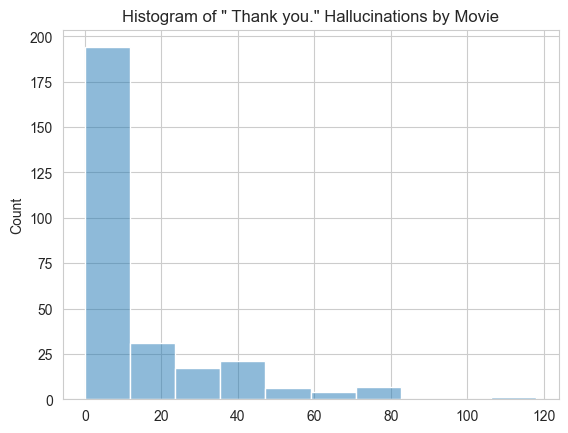

In [11]:
plotting.create_thank_you_hist(trans_df)
# TODO: consider evaluating per segment count or per character count

Text(0.5, 1.0, 'Histogram of Proportion of Text from Narrator by Movie')

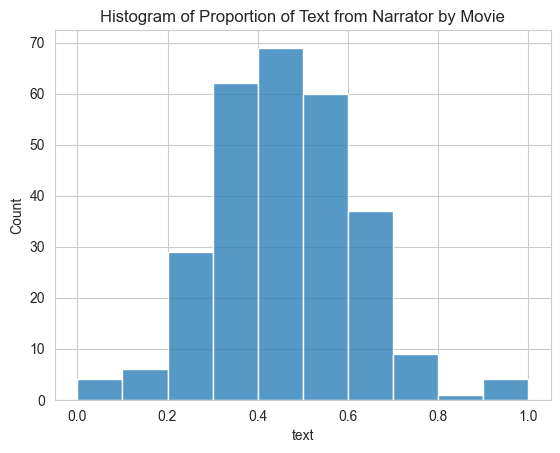

In [ ]:
trans_wc_df = red_trans_df.groupby('movie').text.apply(' '.join).apply(md.process_text, excl_stopwords=False).apply(len)
subs_wc_df = filtered_subs_df.groupby('movie').text.apply(' '.join).apply(md.process_text, excl_stopwords=False).apply(len)

perc_narration_df = trans_wc_df / (subs_wc_df + trans_wc_df)

sns.histplot(perc_narration_df, binrange=(0, 1), bins=10)
plt.title('Histogram of Proportion of Text from Narrator by Movie')

# TODO: investigate super high proportion films

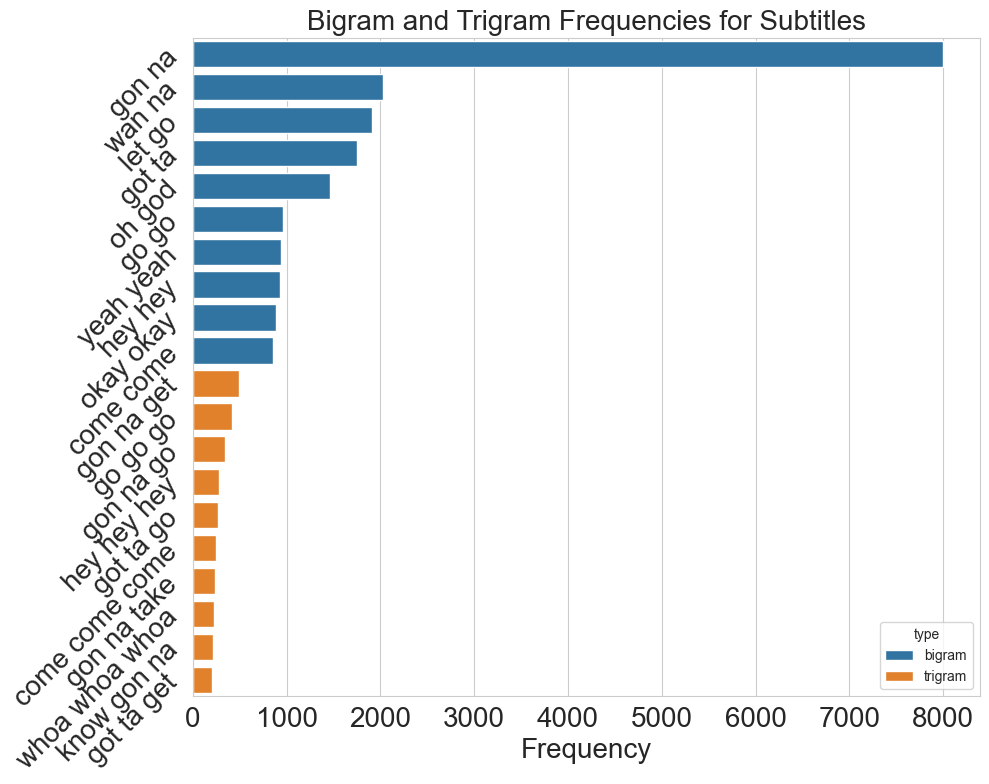

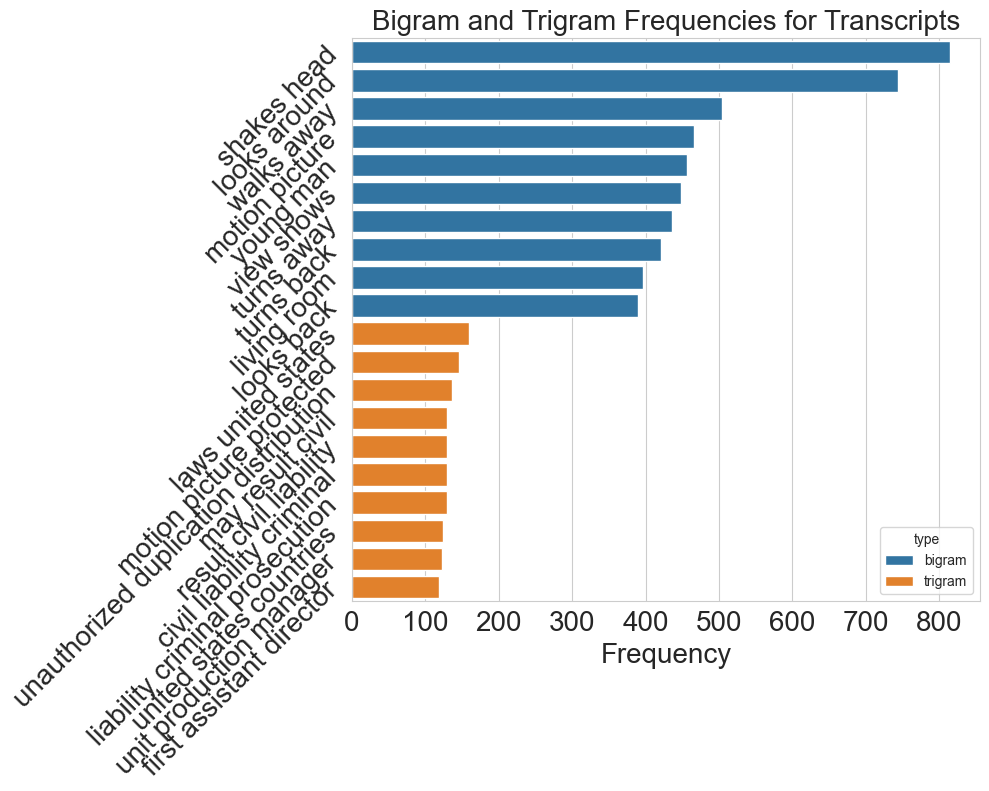

In [13]:
subs_text = ' '.join(filtered_subs_df.text)
trans_text = ' '.join(red_trans_df.text)
dataset = {'Subtitles': subs_text, 'Transcripts': trans_text}

excl_stopwords = True

for title, text in dataset.items():
    bigram_df = md.get_ngram_counts(text, 2, excl_stopwords=excl_stopwords)
    trigram_df = md.get_ngram_counts(text, 3, excl_stopwords=excl_stopwords)

    bigram_df['type'] = 'bigram'
    trigram_df['type'] = 'trigram'

    full_df = pd.concat([bigram_df, trigram_df])
    title = f"Bigram and Trigram Frequencies for {title}"
    plotting.plot_ngrams(full_df, title, os.path.join(plotting.output_dir, f'{title} ngram ranking.png'))

Text(0.5, 1.0, 'Correlation of Ratings Categories')

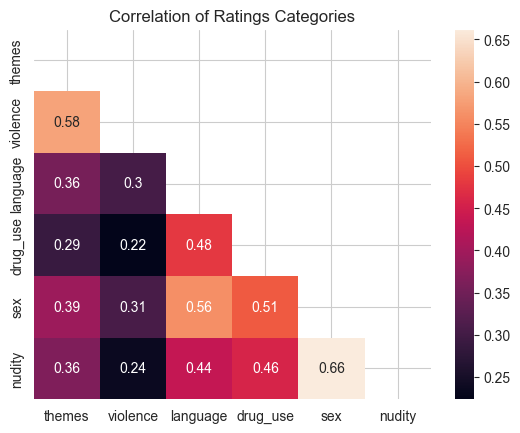

In [14]:
cat_cols = ['themes', 'violence', 'drug_use', 'sex'] 
full_cat_cols = ['themes', 'violence', 'language', 'drug_use', 'sex', 'nudity']
ord_acb_df = acb_df.copy()
for col in full_cat_cols:
    ord_acb_df[col] = md.convert_col_to_ordinal(ord_acb_df[col])

corr_df = ord_acb_df[full_cat_cols].corr()
matrix = np.triu(corr_df)
sns.heatmap(corr_df, annot=True, mask=matrix)
plt.title('Correlation of Ratings Categories')

Text(0.5, 1.0, 'Counts per Aggregated Rating Category')

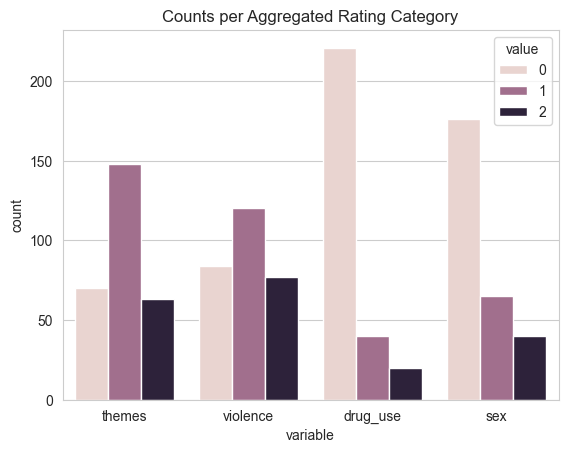

In [15]:
melt_df = pd.melt(ord_acb_df, ['movie'], cat_cols)
sns.countplot(melt_df, x='variable', hue='value')
plt.title('Counts per Aggregated Rating Category')

/tmp/ipykernel_375095/1677357894.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(full_ord_acb_df, x='Classification', palette=plotting.full_acb_palette[1:], order=['G', 'PG', 'M', 'MA15+', 'R18+'])


<Axes: xlabel='Classification', ylabel='count'>

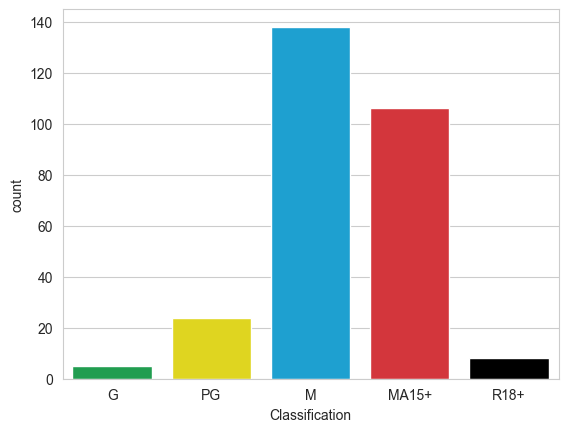

In [16]:
full_ord_acb_df = acb_df.copy()
for col in full_cat_cols:
    full_ord_acb_df[col] = md.convert_col_to_ordinal(full_ord_acb_df[col], compact=False)

full_ord_acb_df['rating'] = full_ord_acb_df[full_cat_cols].max(axis=1)
full_ord_acb_df['Classification'] = np.select(
    [full_ord_acb_df['rating'].eq(ii) for ii in range(1, 6)],
    ['G', 'PG', 'M', 'MA15+', 'R18+'],
    default='Error'
)

sns.countplot(full_ord_acb_df, x='Classification', palette=plotting.full_acb_palette[1:], order=['G', 'PG', 'M', 'MA15+', 'R18+'])

INFO - 2025-06-27 00:03:10,719 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO - 2025-06-27 00:03:10,727 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='overall_code', ylabel='count'>

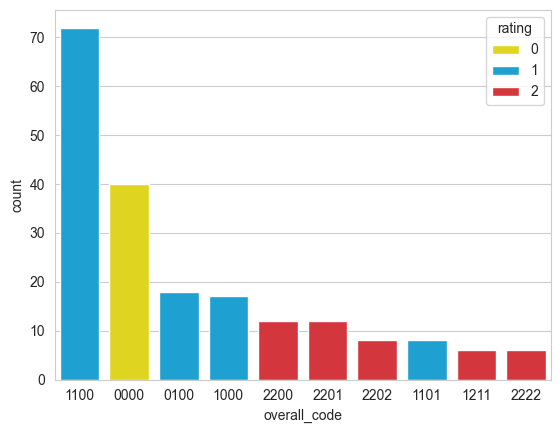

In [17]:
ord_acb_df['overall_code'] = ord_acb_df[cat_cols].astype(str).agg(''.join, axis=1)
ord_acb_df['rating'] = ord_acb_df[cat_cols].max(axis=1)
top_codes = ord_acb_df['overall_code'].value_counts()

top_10_codes = ord_acb_df[ord_acb_df.overall_code.isin(top_codes.index[:10])]
sns.countplot(top_10_codes, x='overall_code', hue='rating', order=top_codes.index[:10], palette=plotting.acb_palette)